In [1]:
import csv
import pandas as pd
import numpy as np
import json
import jsonlines
import re
from termcolor import colored
csv.field_size_limit(100000000)

from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import shap

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse
%matplotlib inline 

import matplotlib.dates as mdates
import matplotlib.ticker as tick

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

pd.options.display.float_format = '{:.4f}'.format

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# RandomForestClassifier
## TweetsCov19
### (Tweet content + user features)

In [2]:
path = '../data/df_tweetscov19_sample_200000.tsv'

df_tweetscov19_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg', 'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent', 'tweet_politic_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female', 'male' , 'work', 'leisure', 'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space', 'time', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted', 'user_vadercompound_average', 'tweet_vadercompound_abweichung', 'tweet_political_polarisation_abweichung', 'tweet_science_polarisation_abweichung', 'tweet_moderacy_polarisation_abweichung' ])

print('Shape :', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape : (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_abweichung,tweet_political_polarisation_abweichung,tweet_science_polarisation_abweichung,tweet_moderacy_polarisation_abweichung
0,1252651655616532480,98432e94b13942101ca1ab63145cb401,1,1,-0.1140,0.6680,0.2180,0.5859,0,0,174,0,63.4800,2,1.1800,0.0000,0.0000,0.0000,18.7500,0.0000,3.1200,0.0000,3.1200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.1200,6.2500,0.0000,0.0000,3.1200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.3800,0.0000,3.1200,0.0000,0.0000,0.0000,12.5000,0.0000,0.0000,9.3800,3.1200,0.0000,0.0000,0.0000,0.0000,12.5000,9.3800,3.1200,3.1200,0.0000,12.5000,0.0000,3.1200,0.0000,0.0000,3.1200,0.0000,0.0000,0.0000,3.1200,6.2500,9.3800,0.0000,0.0000,0.0000,1,1,1.0000,0.5708,True,0.5859,0.0000,0.0000,0.0000,0.0000
1,1191671063760924672,6281afa4db32ffd9ca516f76b2f257eb,189,314,-0.4160,0.5010,0.0830,-0.8732,1,0,122,0,87.5500,7,1.5180,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,92,92,1.0000,0.9998,True,0.3163,-1.1895,0.0000,0.0000,0.0000
2,1199273226066481152,fd186920eb4730f7b564903098a32579,1,1,-0.0000,0.8430,0.1570,0.7717,0,4,192,0,57.7930,5,0.0000,0.0000,0.0000,0.0000,10.3400,0.0000,0.0000,0.0000,0.0000,3.4500,6.9000,0.0000,3.4500,0.0000,0.0000,3.4500,0.0000,3.4500,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,13.7900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,3.4500,0.0000,6.9000,3.4500,0.0000,6.9000,0.0000,0.0000,0.0000,6.9000,3.4500,0.0000,3.4500,3.4500,0.0000,0.0000,10.3400,3.4500,6.9000,3.4500,0.0000,13.7900,3.4500,6.9000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.9000,0.0000,0.0000,0.0000,1,1,1.0000,0.0893,True,0.7717,0.0000,0.0000,0.0000,0.0000
3,1242201195550314499,06b8219c72795f4a84ee9aa58e778786,0,0,-0.0000,1.0000,0.0000,0.0000,4,2,167,1,27.4850,0,0.0000,0.0000,0.0000,0.0000,8.7000,0.0000,0.0000,0.0000,0.0000,8.7000,4.3500,0.0000,4.3500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.7000,0.0000,0.0000,0.0000,0.0000,0.0000,4.3500,4.3500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,21.7400,0.0000,0.0000,4.3500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.7000,0.0000,0.5000,0.0000,-1.0000,6,1,0.1667,0.7134,True,0.0929,0.0000,-0.5000,0.0000,1.0000
4,1190322195735535616,1917db1f6441a3891e78b89264c75155,1,1,-0.0540,0.8690,0.0770,0.4588,1,50,865,2,-91.0600,1,0.2210,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.1500,0.0000,0.0000,0.0000,0.0000,1.1500,0.0000,1.1500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3000,0.0000,1.1500,0.000

In [3]:
df_tweetscov19_user = df_tweetscov19_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape:  (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_abweichung,tweet_political_polarisation_abweichung,tweet_science_polarisation_abweichung,tweet_moderacy_polarisation_abweichung
0,1243579816475086848,43f69d6535059aac0e9fb5078ef586ec,6,7,-0.0000,1.0000,0.0000,0.0000,1,2,116,0,16.1080,0,0.0000,0.0000,0.0000,0.0000,6.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.6700,0.0000,0.0000,0.0000,0.0000,0.0000,13.3300,0.0000,0.0000,6.6700,0.0000,0.0000,0.0000,0.0000,13.3300,13.3300,13.3300,0.0000,0.0000,0.0000,6.6700,6.6700,6.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.6700,6.6700,0.0000,0.0000,0.0000,1,0,0.0000,0.8073,False,0.0000,0.0000,0.0000,0.0000,0.0000
1,1228353308114530306,0c1de191b0a8fdfe1b43b08088602a69,20,53,-0.0340,0.7580,0.2080,0.8516,2,0,287,0,58.2030,0,0.0000,0.0000,0.0000,0.0000,6.8200,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.2700,0.0000,0.0000,0.0000,0.0000,0.0000,2.2700,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,2.2700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.8200,11.3600,0.0000,0.0000,2.2700,0.0000,2.2700,2.2700,2.2700,0.0000,0.0000,2.2700,0.0000,0.0000,0.0000,2.2700,4.5500,0.0000,0.0000,0.0000,0.0000,6,6,1.0000,0.9985,True,0.7382,0.1134,0.0000,0.0000,0.0000
2,1227457952778420226,1ccaafabe8f2187a3ba5594d8bed4e6b,0,0,-0.1260,0.8740,0.0000,-0.3818,0,0,113,0,78.2450,0,0.0000,0.0000,0.0000,0.0000,9.5200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,4.7600,0.0000,14.2900,4.7600,0.0000,9.5200,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.0949,True,-0.3609,-0.0209,0.0000,0.0000,0.0000
3,1242947570281762816,48a3b2d627224509a04cf4d170fc0b0c,8,1,-0.2700,0.6310,0.0990,-0.9001,0,0,284,1,81.1420,0,0.0000,-1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,2.0000,0.0000,2.0000,0.0000,2.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,2.0000,8.0000,2.0000,2.0000,6.0000,0.0000,2.0000,2.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,14.0000,2.0000,2.0000,2.0000,0.0000,12.0000,2.0000,0.0000,2.0000,4.0000,2.0000,0.0000,0.0000,2.0000,2.0000,16.0000,4.0000,-1.0000,1.0000,0.5000,8,0,0.0000,0.3529,False,-0.0941,-0.8060,0.0000,-1.0000,0.5000
4,1180590766306951169,9a1ff274bf14fd2420bc7d3bcebfc959,0,0,-0.0340,0.9660,0.0000,-0.1779,0,2,285,0,59.8580,0,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.

In [4]:
features = df_tweetscov19_user.columns
features

Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg',
       'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num',
       'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent',
       'tweet_politic_polarisation', 'tweet_science_polarisation',
       'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female',
       'male', 'work', 'leisure', 'home', 'money', 'relegion', 'death',
       'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body',
       'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad',
       'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ',
       'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they',
       'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
       'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear',
       'feel', 'motion', 'space', 'tim

In [5]:
df_tweetscov19_user['Is_deleted'] = np.where(df_tweetscov19_user['Is_deleted'] == True, 1, 0)
df_tweetscov19_user.head()

,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_abweichung,tweet_political_polarisation_abweichung,tweet_science_polarisation_abweichung,tweet_moderacy_polarisation_abweichung
0,1243579816475086848,43f69d6535059aac0e9fb5078ef586ec,6,7,-0.0000,1.0000,0.0000,0.0000,1,2,116,0,16.1080,0,0.0000,0.0000,0.0000,0.0000,6.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.6700,0.0000,0.0000,0.0000,0.0000,0.0000,13.3300,0.0000,0.0000,6.6700,0.0000,0.0000,0.0000,0.0000,13.3300,13.3300,13.3300,0.0000,0.0000,0.0000,6.6700,6.6700,6.6700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.6700,6.6700,0.0000,0.0000,0.0000,1,0,0.0000,0.8073,0,0.0000,0.0000,0.0000,0.0000,0.0000
1,1228353308114530306,0c1de191b0a8fdfe1b43b08088602a69,20,53,-0.0340,0.7580,0.2080,0.8516,2,0,287,0,58.2030,0,0.0000,0.0000,0.0000,0.0000,6.8200,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.2700,0.0000,0.0000,0.0000,0.0000,0.0000,2.2700,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,2.2700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.8200,11.3600,0.0000,0.0000,2.2700,0.0000,2.2700,2.2700,2.2700,0.0000,0.0000,2.2700,0.0000,0.0000,0.0000,2.2700,4.5500,0.0000,0.0000,0.0000,0.0000,6,6,1.0000,0.9985,1,0.7382,0.1134,0.0000,0.0000,0.0000
2,1227457952778420226,1ccaafabe8f2187a3ba5594d8bed4e6b,0,0,-0.1260,0.8740,0.0000,-0.3818,0,0,113,0,78.2450,0,0.0000,0.0000,0.0000,0.0000,9.5200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,4.7600,0.0000,14.2900,4.7600,0.0000,9.5200,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.0949,1,-0.3609,-0.0209,0.0000,0.0000,0.0000
3,1242947570281762816,48a3b2d627224509a04cf4d170fc0b0c,8,1,-0.2700,0.6310,0.0990,-0.9001,0,0,284,1,81.1420,0,0.0000,-1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,2.0000,0.0000,2.0000,0.0000,2.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,2.0000,8.0000,2.0000,2.0000,6.0000,0.0000,2.0000,2.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,14.0000,2.0000,2.0000,2.0000,0.0000,12.0000,2.0000,0.0000,2.0000,4.0000,2.0000,0.0000,0.0000,2.0000,2.0000,16.0000,4.0000,-1.0000,1.0000,0.5000,8,0,0.0000,0.3529,0,-0.0941,-0.8060,0.0000,-1.0000,0.5000
4,1180590766306951169,9a1ff274bf14fd2420bc7d3bcebfc959,0,0,-0.0340,0.9660,0.0000,-0.1779,0,2,285,0,59.8580,0,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,2.0000,2.

In [6]:
#df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'Tweet_Id', 'Username', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio'])

In [7]:
def get_X_y(df, features):
    
    if 'Is_deleted' not in features:
        features = np.append(features, 'Is_deleted')
        
    df = df[features.tolist()]
    X = df.drop('Is_deleted', axis=1)
    y = df['Is_deleted']

    y = y.astype(int)
    print(X.shape)
    print(y.shape)
    
    return X,y

In [8]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 89)
(200000,)


In [9]:
def split_train_test_valid(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=15)
    #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=15)
    print(X_train.shape)
    print(X_test.shape)
    #print(X_valid.shape)

    print(y_train.shape)
    print(y_test.shape)
    #print(y_valid.shape)
    return  X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


In [10]:
def fit_random_forest_clf(X,y):

    clf = RandomForestClassifier( n_jobs=-1)
    clf.fit(X,y)
    return clf

In [11]:
def test_random_forest_clf(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    print('Accuracy :', accuracy_score(y_test, y_pred))
    

In [13]:
rf_model = fit_random_forest_clf(X_train, y_train)

In [14]:
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.624675


In [15]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61     19931
           1       0.62      0.67      0.64     20069

    accuracy                           0.62     40000
   macro avg       0.63      0.62      0.62     40000
weighted avg       0.63      0.62      0.62     40000



In [12]:
def plot_confusion_matrix(y_test, y_pred, classes, titel):
    
    confusion_mx = confusion_matrix(y_test, y_pred)
    confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
    
    sns.heatmap(confusion_mx, xticklabels = classes, yticklabels = classes, annot=True)
    plt.title(titel)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

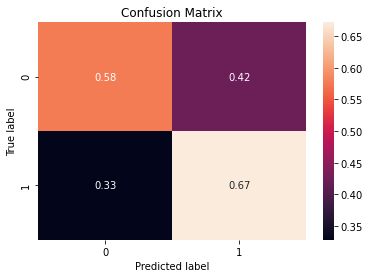

In [17]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

***

In [13]:
def features_classifier_(df, model):

    column_feature = {}

    for i, c in enumerate(df):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = model.feature_importances_[i]
        #print(c)
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)

    df_column_feature = df_column_feature.reset_index()
    df_column_feature
    return df_column_feature

In [19]:
rf_model = RandomForestClassifier(n_estimators = 1000 , random_state=20, max_features = 'sqrt',max_depth = 10, min_samples_split = 2, min_samples_leaf=1, bootstrap = True, n_jobs=-1)

rf_model.fit(X_train, y_train)

f_importances = features_classifier_(X_train, rf_model)
f_importances

,index,Feature,importance
0,83,user_Reputation,0.1626
1,80,user_political_polarisation,0.0676
2,81,user_science_polarisation,0.0553
3,82,user_moderacy_polarisation,0.0537
4,9,URLs_num,0.0487
5,87,tweet_science_polarisation_abweichung,0.0364
6,0,Retweets,0.0358
7,84,user_vadercompound_average,0.0332
8,8,Text_len,0.0316
9,86,tweet_political_polarisation_abweichung,0.0299


In [20]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'user_political_polarisation'
 'user_science_polarisation' 'user_moderacy_polarisation' 'URLs_num'
 'tweet_science_polarisation_abweichung' 'Retweets'
 'user_vadercompound_average' 'Text_len'
 'tweet_political_polarisation_abweichung' 'Hashtags_num' 'Favorites'
 'tweet_moderacy_polarisation_abweichung' 'tweet_politic_polarisation'
 'informal' 'i' 'work' 'prep' 'tweet_moderacy_polarisation' 'readability'
 'swear' 'verb' 'vader_com' 'Vader_neg']


In [21]:
len(f_importances)

24

In [22]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(200000, 24)
(200000,)


In [14]:
def print_cross_val_score(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, scoring='precision')
    print(" percision : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='f1')
    print(" f1        : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='recall')
    print(" recall    : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

In [27]:
%%time
rf_model = RandomForestClassifier(n_estimators = 1000 , random_state=20, max_features = 'sqrt',max_depth = 10, min_samples_split = 2, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(rf_model, X_new, y)

 percision : 0.60 +/- 0.007
 f1        : 0.66 +/- 0.009
 recall    : 0.74 +/- 0.015
Wall time: 2min 43s


In [28]:
%%time
rf_model = RandomForestClassifier(n_estimators = 1000 , random_state=20, max_features = 'sqrt',max_depth = 10, min_samples_split = 2, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(rf_model, X, y)

 percision : 0.60 +/- 0.010
 f1        : 0.66 +/- 0.011
 recall    : 0.72 +/- 0.017
Wall time: 2min 45s


******

***

***

In [27]:
n_estimators = [100, 200, 300, 400, 500, 1000]
max_features = ['sqrt', 'log2', 'auto']
max_depth =  [2,4,6,8,10]
min_samples_split = [2,4,8]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

In [28]:
param_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 1000], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [29]:
rf_model = RandomForestClassifier()

In [30]:
clf_grid = GridSearchCV(rf_model, param_grid = param_grid, cv = 3, verbose = 2, n_jobs = -1)
clf_grid.fit(X_train,y_train)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200, 300, 400, 500, 1000]},
             verbose=2)

In [31]:
clf_grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [32]:
clf_grid.score(X_test,y_test)

0.616

****

In [25]:
%%time
#200 000 Tweets

clf_cv = RandomForestClassifier(n_estimators = 1000 , random_state=20, max_features = 'sqrt',max_depth = 10, min_samples_split = 2, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)


 percision : 0.60 +/- 0.002
 f1        : 0.66 +/- 0.003
 recall    : 0.73 +/- 0.006
Wall time: 23min 15s


***

In [69]:
def plot_hist_Features(l_features_importances, l_features, titel):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue', 'peru', 'black', 'mediumslateblue', 'lightblue']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
    #plt.legend()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [70]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Reputation', 'Likes', 'Retweets', 'Political p.u.', 'Moderacy p.u.']

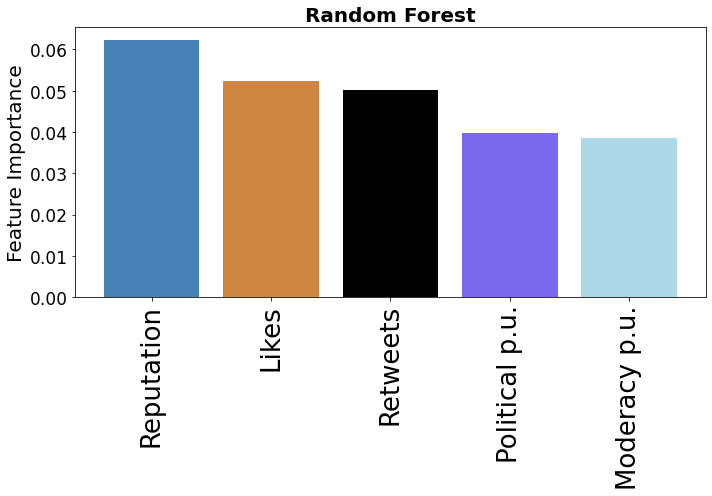

In [72]:
plot_hist_Features(l_features_importances, l_features, 'Rf_TweetsCov19_content_User(reputation)_o_moderacy_all_del')

************************************************
************************************************

## TweetsCov19
### (Content only)

In [15]:
features = df_tweetscov19_user.columns
features

#features = features[2:83]
df_tweetscov19_user = df_tweetscov19_user[features.tolist()]
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_vadercompound_average', 'tweet_vadercompound_abweichung', 'tweet_political_polarisation_abweichung', 'tweet_science_polarisation_abweichung', 'tweet_moderacy_polarisation_abweichung' ])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation'])


In [16]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 80)
(200000,)


In [17]:
X_train, X_test, y_train, y_test= split_train_test_valid(X,y)

(160000, 80)
(40000, 80)
(160000,)
(40000,)


In [18]:
%%time
rf_model = fit_random_forest_clf(X_train, y_train)
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.5893
Wall time: 13.1 s


In [19]:
clf_cv = RandomForestClassifier(n_estimators = 1000 , random_state=20, max_features = 'sqrt',max_depth = 10, min_samples_split = 2, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
clf_cv.fit(X_train, y_train)

f_importances = features_classifier_(X, clf_cv)
f_importances

,index,Feature,importance
0,9,URLs_num,0.0756
1,0,Retweets,0.0626
2,1,Favorites,0.0553
3,8,Text_len,0.0530
4,13,tweet_politic_polarisation,0.0506
5,6,Hashtags_num,0.0383
6,15,tweet_moderacy_polarisation,0.0370
7,21,work,0.0337
8,63,prep,0.0312
9,27,informal,0.0296


In [20]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['URLs_num' 'Retweets' 'Favorites' 'Text_len' 'tweet_politic_polarisation'
 'Hashtags_num' 'tweet_moderacy_polarisation' 'work' 'prep' 'informal' 'i'
 'verb' 'tweet_science_polarisation' 'readability' 'vader_com' 'Vader_neg'
 'swear' 'ipron' 'space' 'Vader_neu' 'focuspresent' 'netspeak'
 'Mentions_num' 'time' 'Emoji_num' 'conj' 'social' 'article' 'affiliation'
 'auxverb' 'negemo' 'adverb' 'Vader_pos' 'Emoji_sent' 'adj' 'sexual']


In [21]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(200000, 36)
(200000,)


In [33]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 1000 , random_state=20, max_features = 'sqrt',max_depth = 10, min_samples_split = 2, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(rf_model, X_new, y)

 percision : 0.59 +/- 0.003
 f1        : 0.62 +/- 0.004
 recall    : 0.64 +/- 0.005
Wall time: 5min 50s


In [34]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 1000 , random_state=20, max_features = 'sqrt',max_depth = 10, min_samples_split = 2, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(rf_model, X, y)

 percision : 0.60 +/- 0.003
 f1        : 0.62 +/- 0.004
 recall    : 0.65 +/- 0.006
Wall time: 8min 47s


********************************************************
********************************************************

In [22]:
%%time
#200 000 Tweeets
clf_cv = RandomForestClassifier(n_estimators = 1000 , random_state=20, max_features = 'sqrt',max_depth = 10, min_samples_split = 2, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(rf_model, X, y)

 percision : 0.59 +/- 0.003
 f1        : 0.60 +/- 0.004
 recall    : 0.61 +/- 0.005
Wall time: 8min 9s


***

## Plot feature Imortances
### TweetCov19 (Content Only)

In [42]:
def plot_hist_Features_content_only(l_features_importances, l_features, titel):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['peru', 'black', 'mediumslateblue', 'lightblue', 'lightgreen']
    
    x = np.arange(len(l_features))

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=18)
    ax.set_ylabel('Feature Importance', fontsize=20)
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
    fig.tight_layout()
    

    #plt.legend()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [43]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Likes', 'Retweets', 'Text l.', 'Readability', 'Sentiment']

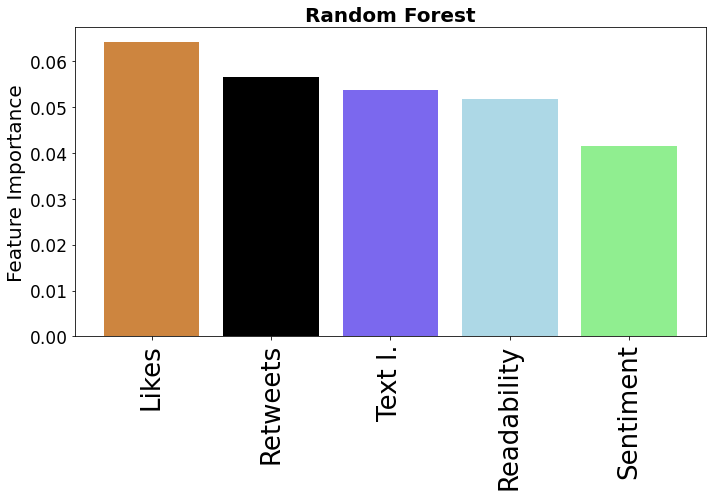

In [44]:
plot_hist_Features_content_only(l_features_importances, l_features, 'Rf_TweetsCov19_content_only_o_moderacy_all_del')

************************************************
************************************************

# Tweetskb
### (Content + User Features)

In [24]:
path = '../data/df_tweetskb_sample_200000.tsv'

df_tweetskb_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg', 'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent', 'tweet_politic_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female', 'male' , 'work', 'leisure', 'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space', 'time', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted', 'user_vadercompound_average', 'tweet_vadercompound_abweichung', 'tweet_political_polarisation_abweichung', 'tweet_science_polarisation_abweichung', 'tweet_moderacy_polarisation_abweichung' ])

print('Shape :', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape : (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_abweichung,tweet_political_polarisation_abweichung,tweet_science_polarisation_abweichung,tweet_moderacy_polarisation_abweichung
0,1183735622982344705,ScandalofSpeed,2,10,-0.0790,0.8860,0.0350,-0.3382,0,0,187,0,60.1090,0,0.0000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,3.4500,0.0000,3.4500,6.9000,0.0000,0.0000,0.0000,3.4500,0.0000,0.0000,10.3400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4500,3.4500,6.9000,10.3400,3.4500,3.4500,6.9000,0.0000,0.0000,3.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.9000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.8471,True,-0.3382,0.0000,0.0000,0.0000,0.0000
1,1219313839151423495,pwns4cash,0,0,-0.0000,0.7060,0.2940,0.3612,0,1,41,0,78.8730,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14.2900,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14.2900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.6873,True,0.3612,0.0000,0.0000,0.0000,0.0000
2,1188314245760311296,MadMax26125746,0,0,-0.2680,0.7320,0.0000,-0.5106,0,1,63,0,52.8650,0,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,0.0000,9.0900,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,18.1800,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,0.0000,9.0900,0.0000,18.1800,0.0000,0.0000,0.0000,18.1800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.7047,True,-0.5106,0.0000,0.0000,0.0000,0.0000
3,1199082882238537729,kirstenigot,0,0,-0.0000,0.7410,0.2590,0.6739,2,0,105,1,53.6390,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.2500,True,0.4918,0.1821,0.0000,0.0000,0.0000
4,1209565509068500992,pie_yann,0,0,-0.6940,0.3060,0.0000,-0.7783,0,2,34,0,66.4000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,40.0000,40.0000,0.0000,0.0000,0.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.0000,20.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.

In [25]:
features = df_tweetskb_user.columns
#features

In [26]:
df_tweetskb_user['Is_deleted'] = np.where(df_tweetskb_user['Is_deleted'] == True, 1, 0)
df_tweetskb_user.tail()

,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_abweichung,tweet_political_polarisation_abweichung,tweet_science_polarisation_abweichung,tweet_moderacy_polarisation_abweichung
199995,1199740653963489285,brinabobina15,0,0,-0.0000,0.3610,0.6390,0.6486,0,1,22,0,75.8750,1,0.0000,0.0000,0.0000,0.0000,33.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,33.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.5307,0,0.5796,0.0690,0.0000,0.0000,0.0000
199996,1226682818048118784,eunhyedoo,4,18,-0.0990,0.9010,0.0000,-0.3182,0,0,117,0,65.2960,0,0.0000,0.0000,0.0000,0.0000,18.1800,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,4.5500,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,4.5500,4.5500,9.0900,9.0900,4.5500,9.0900,4.5500,22.7300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,13,0,0.0000,0.4211,0,-0.0021,-0.3161,0.0000,0.0000,0.0000
199997,1263852788280430593,Harleysdad65,35,139,-0.1350,0.5810,0.2840,0.8934,0,0,120,0,100.0150,5,0.2157,0.0000,0.0000,0.0000,14.2900,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,4.7600,0.0000,4.7600,0.0000,0.0000,9.5200,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,0.0000,4.7600,14.2900,14.2900,4.7600,0.0000,9.5200,14.2900,4.7600,4.7600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.7600,14.2900,0.0000,0.0000,0.0000,0.0000,24,0,0.0000,0.6314,0,0.3977,0.4957,0.0000,0.0000,0.0000
199998,1230926459776061440,USLTER,1,1,-0.0000,0.8300,0.1700,0.7993,4,2,285,1,52.2450,0,0.0000,0.0000,0.0000,0.0000,4.6500,0.0000,0.0000,0.0000,0.0000,6.9800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3300,2.3300,2.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.6500,0.0000,0.0000,0.0000,4.6500,0.0000,0.0000,2.3300,2.3300,13.9500,4.6500,0.0000,0.0000,0.0000,6.9800,2.3300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.6500,2.3300,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.8019,0,0.7993,0.0000,0.0000,0.0000,0.0000
199999,1215871785591353345,kpoplover727,102,239,-0.0000,0.7200,0.2800,0.9648,0,0,264,0,37.6580,1,0.0000,0.0000,0.0000,0.0000,5.7700,0.0000,0.0000,0.0000,0.0000,3.8500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.6900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.8500,1.9200,0.0000,1.9200,1.9200,0.0000,0.0000,0.0000,1.9200,13.4600,1.9200

In [27]:
df_tweetskb_user = df_tweetskb_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape:  (200000, 95)


,Tweet_Id,Username,Retweets,Favorites,Vader_neg,Vader_neu,Vader_pos,vader_com,Hashtags_num,Mentions_num,Text_len,URLs_num,readability,Emoji_num,Emoji_sent,tweet_politic_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,social,family,friend,female,male,work,leisure,home,money,relegion,death,informal,swear,netspeak,assent,nonflu,filler,body,health,sexual,ingest,posemo,negemo,anx,anger,sad,insight,cause,discrep,tentat,certain,differ,affiliation,achiev,power,reward,risk,focuspast,focuspresent,focusfuture,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,see,hear,feel,motion,space,time,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_num_posted_tweets,user_num_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted,user_vadercompound_average,tweet_vadercompound_abweichung,tweet_political_polarisation_abweichung,tweet_science_polarisation_abweichung,tweet_moderacy_polarisation_abweichung
0,1236088471460155392,CYDharta,0,0,-0.0550,0.8810,0.0640,0.0880,0,4,228,0,72.0730,0,0.0000,0.0000,0.0000,0.0000,10.2600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.5600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.6900,2.5600,7.6900,0.0000,0.0000,0.0000,0.0000,0.0000,5.1300,5.1300,0.0000,0.0000,2.5600,0.0000,7.6900,2.5600,2.5600,15.3800,10.2600,0.0000,7.6900,0.0000,23.0800,2.5600,0.0000,0.0000,0.0000,0.0000,2.5600,0.0000,0.0000,5.1300,2.5600,0.0000,0.0000,0.0000,0.0000,0.0000,3,0,0.0000,0.3357,0,-0.0363,0.1243,0.0000,0.0000,0.0000
1,1221491748276334592,jonisfrontporch,0,0,-0.2000,0.6450,0.1550,-0.3400,0,0,170,0,68.9400,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.5700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.5700,0.0000,0.0000,7.1400,0.0000,0.0000,0.0000,0.0000,7.1400,0.0000,3.5700,0.0000,0.0000,0.0000,0.0000,10.7100,0.0000,0.0000,3.5700,10.7100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,21.4300,7.1400,0.0000,0.0000,0.0000,10.7100,0.0000,0.0000,0.0000,3.5700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.7100,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.5471,1,-0.3400,0.0000,0.0000,0.0000,0.0000
2,1194436725851983872,muvalashay,0,0,-0.1890,0.6150,0.1960,0.1007,0,0,114,0,65.2960,3,0.0000,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,0.0000,0.0000,0.0000,9.0900,0.0000,4.5500,0.0000,0.0000,13.6400,9.0900,4.5500,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,9.0900,0.0000,4.5500,0.0000,4.5500,0.0000,4.5500,4.5500,0.0000,9.0900,0.0000,0.0000,0.0000,0.0000,0.0000,4.5500,4.5500,9.0900,0.0000,0.0000,0.0000,4.5500,0.0000,0.0000,9.0900,0.0000,9.0900,0.0000,4.5500,0.0000,0.0000,9.0900,0.0000,0.0000,4.5500,0.0000,9.0900,0.0000,0.0000,0.0000,4.5500,4.5500,4.5500,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.6129,1,0.1007,0.0000,0.0000,0.0000,0.0000
3,1240391152081264642,DaShaunLH,0,0,-0.0000,0.4410,0.5590,0.5859,0,0,21,0,97.0250,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,25.0000,0.0000,0.0000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,0.0000,1.0000,57,0,0.0000,0.9575,0,0.0179,0.5680,1.0000,0.0000,-1.0000
4,1242404652001497088,crystalpulse,1,1,-0.0240,0.8730,0.1020,0.5897,3,0,287,0,68.9830,0,0.0000,0.0000,0.0000,0.0000,15.3800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.9200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.9200,0.0000,1.9200,0.0000,0.0000,1.9200,0.0000,1.9200,0.0000,1.9200,3.8500,0.0000,3.8500,0.0000,0.0000,7.6900,1.9200,0.0000,0.0000,3.8500,0.000

In [28]:
print(len(features))
features

95


Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg',
       'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num',
       'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent',
       'tweet_politic_polarisation', 'tweet_science_polarisation',
       'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female',
       'male', 'work', 'leisure', 'home', 'money', 'relegion', 'death',
       'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body',
       'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad',
       'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ',
       'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they',
       'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
       'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear',
       'feel', 'motion', 'space', 'tim

In [29]:
#df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'Tweet_Id', 'Username', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio'])

In [30]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 89)
(200000,)


In [31]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


In [32]:
rf_model = fit_random_forest_clf(X_train, y_train)
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.569625


In [33]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57     19977
           1       0.57      0.57      0.57     20023

    accuracy                           0.57     40000
   macro avg       0.57      0.57      0.57     40000
weighted avg       0.57      0.57      0.57     40000



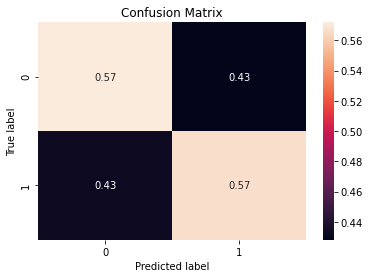

In [34]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

In [35]:
clf_cv = RandomForestClassifier(n_estimators = 1000, min_samples_split= 2, min_samples_leaf= 4, max_features= 'auto', max_depth = 10, bootstrap= True, n_jobs=-1)

clf_cv.fit(X_train, y_train)

f_importances = features_classifier_(X, clf_cv)
f_importances

,index,Feature,importance
0,83,user_Reputation,0.0930
1,55,focusfuture,0.0512
2,8,Text_len,0.0457
3,27,informal,0.0404
4,62,article,0.0386
5,21,work,0.0347
6,9,URLs_num,0.0337
7,80,user_political_polarisation,0.0320
8,84,user_vadercompound_average,0.0318
9,81,user_science_polarisation,0.0271


In [36]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'focusfuture' 'Text_len' 'informal' 'article' 'work'
 'URLs_num' 'user_political_polarisation' 'user_vadercompound_average'
 'user_science_polarisation' 'netspeak' 'Hashtags_num'
 'user_moderacy_polarisation' 'readability' 'sexual' 'motion' 'vader_com'
 'tweet_science_polarisation_abweichung' 'ipron' 'Mentions_num'
 'Vader_neu' 'Retweets' 'Favorites' 'tweet_vadercompound_abweichung'
 'swear' 'Vader_pos' 'Vader_neg' 'social' 'negate'
 'tweet_political_polarisation_abweichung' 'space' 'Emoji_num' 'focuspast'
 'Emoji_sent' 'achiev' 'prep']


In [37]:
X_new,y = get_X_y(df_tweetskb_user, f_importances)

(200000, 36)
(200000,)


In [40]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 1000, min_samples_split= 2, min_samples_leaf= 4, max_features= 'auto', max_depth = 10, bootstrap= True, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.56 +/- 0.009
 f1        : 0.60 +/- 0.008
 recall    : 0.66 +/- 0.008
Wall time: 56.9 s


In [41]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 1000, min_samples_split= 2, min_samples_leaf= 4, max_features= 'auto', max_depth = 10, bootstrap= True, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.56 +/- 0.008
 f1        : 0.61 +/- 0.007
 recall    : 0.66 +/- 0.009
Wall time: 2min 22s


***

In [26]:
n_estimators = [100, 200, 300, 400, 500, 1000]
max_features = ['sqrt', 'log2', 'auto']
max_depth =  [2,4,6,8,10]
min_samples_split = [2,4,8]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

In [27]:
param_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 1000], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [28]:
rf_model = RandomForestClassifier()

In [29]:
%%time
clf_grid = GridSearchCV(rf_model, param_grid = param_grid, cv = 3, verbose = 10, n_jobs = -1)
clf_grid.fit(X_train,y_train)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
Wall time: 59min 28s


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200, 300, 400, 500, 1000]},
             verbose=10)

In [30]:
clf_grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [38]:
%%time
#200 000 Tweets
clf_cv = RandomForestClassifier(n_estimators = 1000, min_samples_split= 2, min_samples_leaf= 4, max_features= 'auto', max_depth = 10, bootstrap= True, n_jobs=-1)

print_cross_val_score(clf_cv, X, y)

 percision : 0.57 +/- 0.002
 f1        : 0.60 +/- 0.003
 recall    : 0.64 +/- 0.007
Wall time: 33min 37s


*****************************************************
*****************************************************

## Plot feature Imortances
### Tweetkb (Content + User)

In [26]:
def plot_hist_Features_kb(l_features_importances, l_features, titel):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue','Black', 'peru', 'mediumslateblue', 'lightgreen']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
   #plt.legend()
    plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [27]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Reputation', 'Text l.', 'Readability', 'Sentiment', 'Verb']

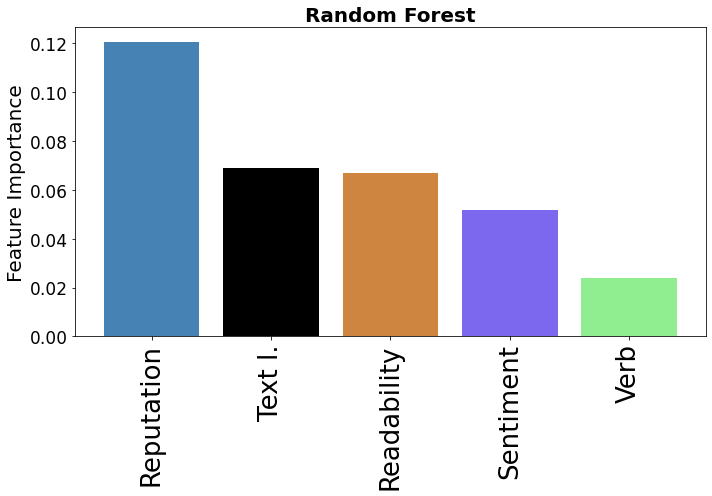

In [28]:
plot_hist_Features_kb(l_features_importances, l_features, 'Rf_Tweetskb_content_User(reputation)_2_o_moderacy_all_del')

***********************************************************************
***********************************************************************

## Tweetskb
### Content only


In [39]:
features = df_tweetskb_user.columns
features

#features = features[2:83]
df_tweetskb_user = df_tweetskb_user[features.tolist()]
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_vadercompound_average', 'tweet_vadercompound_abweichung', 'tweet_political_polarisation_abweichung', 'tweet_science_polarisation_abweichung', 'tweet_moderacy_polarisation_abweichung' ])
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation'])


In [40]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 80)
(200000,)


In [41]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 80)
(40000, 80)
(160000,)
(40000,)


In [42]:
clf_cv = RandomForestClassifier(n_estimators = 1000, min_samples_split= 2, min_samples_leaf= 4, max_features= 'auto', max_depth = 10, bootstrap= True, n_jobs=-1)
clf_cv.fit(X_train, y_train)

f_importances = features_classifier_(X, clf_cv)
f_importances

,index,Feature,importance
0,55,focusfuture,0.0618
1,8,Text_len,0.0557
2,27,informal,0.0473
3,62,article,0.0455
4,9,URLs_num,0.0419
5,21,work,0.0410
6,6,Hashtags_num,0.0313
7,29,netspeak,0.0289
8,5,vader_com,0.0265
9,10,readability,0.0262


In [43]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['focusfuture' 'Text_len' 'informal' 'article' 'URLs_num' 'work'
 'Hashtags_num' 'netspeak' 'vader_com' 'readability' 'sexual' 'ipron'
 'motion' 'Vader_neu' 'Vader_neg' 'Favorites' 'Retweets' 'Mentions_num'
 'Vader_pos' 'swear' 'social' 'negate' 'space' 'achiev'
 'tweet_politic_polarisation' 'Emoji_num' 'focuspast' 'Emoji_sent'
 'leisure' 'prep' 'auxverb' 'adverb' 'they' 'verb' 'posemo' 'negemo'
 'tweet_moderacy_polarisation' 'we' 'affiliation' 'power']


In [44]:
X_new,y = get_X_y(df_tweetskb_user, f_importances)

(200000, 40)
(200000,)


In [49]:
%%time
#20000 Tweets
clf_cv = RandomForestClassifier(n_estimators = 1000, min_samples_split= 2, min_samples_leaf= 4, max_features= 'auto', max_depth = 10, bootstrap= True, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.56 +/- 0.006
 f1        : 0.59 +/- 0.006
 recall    : 0.63 +/- 0.011
Wall time: 2min 11s


In [50]:
%%time
#20000 Tweets
clf_cv = RandomForestClassifier(n_estimators = 1000, min_samples_split= 2, min_samples_leaf= 4, max_features= 'auto', max_depth = 10, bootstrap= True, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.56 +/- 0.005
 f1        : 0.60 +/- 0.007
 recall    : 0.64 +/- 0.011
Wall time: 2min 7s


In [45]:
%%time
#200 000 Tweets
clf_cv = RandomForestClassifier(n_estimators = 1000, min_samples_split= 2, min_samples_leaf= 4, max_features= 'auto', max_depth = 10, bootstrap= True, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.56 +/- 0.002
 f1        : 0.59 +/- 0.004
 recall    : 0.62 +/- 0.008
Wall time: 28min 55s


***************************************************
***************************************************

## Plot feature Imortances
### Tweetkb (Content Only )

In [73]:
def plot_hist_Features_content_only_kb(l_features_importances, l_features, titel):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['black', 'peru', 'mediumslateblue', 'lightblue', 'lightgreen']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
 
    #plt.legend()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [74]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Likes', 'Readability', 'Text l.', 'Retweets', 'Sentiment']

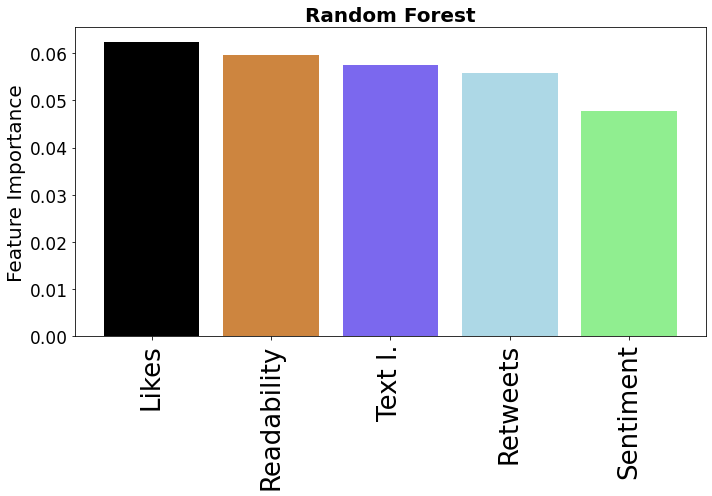

In [75]:
plot_hist_Features_content_only_kb(l_features_importances, l_features, 'Rf_Tweetskb_content_only_ohne_moderacy_alle_del')